# Street sign with Pre-Trained WideResNet

With additional shield net 

In [106]:
from torch.utils.data import Dataset, DataLoader
from os.path import join
import pandas as pd 
from PIL import Image
from torch.optim import SGD
import seaborn as sb 
from gtsrb import GTSRB
from detectors import EnsembleDetector, SemanticDetector
sb.set()

device="cuda:0"
root = "data/"

import torch
torch.manual_seed(0)

import numpy as np
np.random.seed(0)

import random
random.seed(0)

torch.use_deterministic_algorithms(False)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)


In [107]:
import torchvision
from torchvision.transforms import ToTensor, Resize, Compose
import torch 
from torch.utils.data import DataLoader

trans = Compose([ToTensor(), Resize((32, 32))])

train_data = GTSRB(root=root, train=True, transforms=trans)
test_data = GTSRB(root=root, train=False, transforms=trans)

In [108]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, worker_init_fn=seed_worker)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2, worker_init_fn=seed_worker)

In [109]:
from torch import nn
from torchvision.models.resnet import resnet18
from pytorch_ood.model import WideResNet

# def override 
def Model(num_classes=None, *args, **kwargs):
    model = WideResNet(*args, num_classes=1000, **kwargs, pretrained="imagenet32")
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


In [110]:
from tqdm.notebook import tqdm 
import numpy as np 

def train_model(att_index, num_classes):
    """
    train a model for the given attribute index 
    """
    trans = Compose([ToTensor(), Resize((32, 32))])
    train_data = GTSRB(root=root, train=True, transforms=trans)
    test_data = GTSRB(root=root, train=False, transforms=trans)
    
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, worker_init_fn=seed_worker)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2, worker_init_fn=seed_worker)
    
    model = Model(num_classes=num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)

    accs = []

    for epoch in range(20):
        running_loss = 0.0
        model.train()
        bar = tqdm(train_loader)
        for inputs, y in bar:
            labels = y[:, att_index]
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss = 0.8 * running_loss + 0.2 * loss.item()
            bar.set_postfix({"loss": running_loss})

        correct = 0
        total = 0

        with torch.no_grad():
            model.eval()

            for inputs, y in test_loader:
                labels = y[:, att_index]
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Accuracy of the network on the test images: {correct / total:.2%}')

    return model 

# Sign Network 

In [111]:
from torch.utils.data import DataLoader
from pytorch_ood.utils import is_known
from tqdm.notebook import tqdm 
from pytorch_ood.dataset.img import TinyImages300k
from pytorch_ood.utils import ToUnknown
from torch.utils.data import random_split

def train_sign_model():
    tiny = TinyImages300k(root=root, download=True, transform=trans, target_transform=ToUnknown())
    data_train_out, data_test_out, _ = random_split(tiny, [50000, 10000, 240000], generator=torch.Generator().manual_seed(123))

    train_data_noatt = GTSRB(root=root, train=True, transforms=trans, target_transform=lambda y: y[0])
    test_data_noatt = GTSRB(root=root, train=False, transforms=trans, target_transform=lambda y: y[0])

    new_loader = DataLoader(train_data_noatt + data_train_out, batch_size=32, shuffle=True, num_workers=10, worker_init_fn=seed_worker)
    new_test_loader = DataLoader(test_data_noatt + data_test_out, batch_size=32, shuffle=False, num_workers=10, worker_init_fn=seed_worker)

    model = Model(num_classes=2).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)

    accs = []

    for epoch in range(20):
        running_loss = 0.0
        model.train()
        
        bar = tqdm(new_loader)
        for inputs, y in bar:
            labels = is_known(y).long()
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss = 0.8 * running_loss + 0.2 * loss.item()
            bar.set_postfix({"loss": running_loss})

        correct = 0
        total = 0

        with torch.no_grad():
            model.eval()

            for inputs, y in new_test_loader:
                labels = is_known(y).long()
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Accuracy of the shape network on the test images: {correct / total:.2%}')
        accs.append(correct / total)

    return model 

# OOD Evaluation 

In [112]:
from pytorch_ood.dataset.img import (LSUNCrop, LSUNResize, Textures, TinyImageNetCrop, TinyImageNetResize)
from pytorch_ood.detector import EnergyBased, MaxSoftmax
from pytorch_ood.utils import ToRGB, OODMetrics

def evaluate(label_net, shape_net, color_net, shield_net):
    _ = label_net.eval()
    _ = shape_net.eval()
    _ = color_net.eval()
    _ = shield_net.eval()
    
    results = []

    trans = Compose([Resize(size=(32, 32)), ToRGB(), ToTensor()])
    data_in = GTSRB(root=root, train=False, transforms=trans, target_transform=lambda y: y[0])
    # dataset_out_test = Textures(root=root, transform=trans, target_transform=ToUnknown(), download=True)
    
    
    detectors = {
        "MSP": MaxSoftmax(label_net),
        "Energy": EnergyBased(label_net),
        "Semantic-OE": SemanticDetector(
            label_net, 
            shape_net, 
            color_net, 
            GTSRB(root=root).class_to_shape, 
            GTSRB(root=root).class_to_color, 
            sign_net=shield_net
        ),
        "Semantic": SemanticDetector(
                label_net, 
                shape_net, 
                color_net, 
                GTSRB(root=root).class_to_shape, 
                GTSRB(root=root).class_to_color, 
        ),
        "Ensemble": EnsembleDetector(label_net, shape_net, color_net)
    }
    
    datasets = {d.__name__: d for d in (LSUNCrop, LSUNResize, Textures, TinyImageNetCrop, TinyImageNetResize)}
    
    for detector_name, detector in detectors.items():
        for data_name, dataset_c in datasets.items():
            data_out = dataset_c(root=root, transform=trans, target_transform=ToUnknown(), download=True)
            loader = DataLoader(data_in+data_out, batch_size=1024, shuffle=False, worker_init_fn=seed_worker)
            
            scores = []
            ys = []
            
            with torch.no_grad():
                for x, y in loader:
                    scores.append(detector(x.to(device)))
                    ys.append(y.to(device))
                    
                scores = torch.cat(scores, dim=0).cpu()
                ys = torch.cat(ys, dim=0).cpu()
            
            metrics = OODMetrics()
            metrics.update(scores, ys)
            r = metrics.compute()
            r.update({
                "Method": detector_name,
                "Dataset": data_name
            })
            print(r)
            results.append(r)
    
    return results 

In [113]:
def evaluate_acc(net, att_idx=0, oe=False):
    _ = net.eval()
    
    if oe:
        target_trans = lambda y: torch.tensor(1)
    else:
         target_trans = lambda y: y[att_idx]

    trans = Compose([Resize(size=(32, 32)), ToRGB(), ToTensor()])
    data_in = GTSRB(root=root, train=False, transforms=trans, target_transform=target_trans)
    loader = DataLoader(data_in, batch_size=1024, shuffle=False, worker_init_fn=seed_worker)
            
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            predicted = outputs.max(dim=1).indices
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total  

def evaluate_accs(label_net, shape_net, color_net, shield_net):
    r = {}
    names = ("Label", "Color", "Shape",)
    
    for n, net in enumerate((label_net, color_net, shape_net)): 
        acc = evaluate_acc(net, n)
        r[names[n]] = acc
    
    acc = evaluate_acc(shield_net, oe=True)
    r["Sign"] = acc
    
    return [r] 

In [114]:
results = []
results_acc = []

for trial in range(1):
    shield_net = train_sign_model()
    shape_net = train_model(att_index=2, num_classes=5)
    color_net = train_model(att_index=1, num_classes=4)
    label_net = train_model(att_index=0, num_classes=43)
    
    res = evaluate(label_net, shape_net, color_net, shield_net)
    res_acc = evaluate_accs(label_net, shape_net, color_net, shield_net)
    
    for r in res:
        r.update({"Seed": trial})
        
    for r in res_acc:
        r.update({"Seed": trial})
    
    results += res
    results_acc += res_acc

  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.93%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.96%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.96%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.96%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.91%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.90%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.99%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.92%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.71%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.86%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.93%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.99%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.35%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.99%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 97.43%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.10%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 97.93%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.46%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.54%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.89%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.73%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.84%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.48%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.84%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.60%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.60%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.02%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.88%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.88%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.80%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.92%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.88%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.86%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.82%
{'AUROC': 0.9897793531417847, 'AUPR-IN': 0.9835981130599976, 'AUPR-OUT': 0.992241382598877, 'ACC95TPR': 0.9634997844696045, 'FPR95TPR': 0.025811560451984406, 'Method': 'MSP', 'Dataset': 'LSUNCrop'}
{'AUROC': 0.9963836669921875, 'AUPR-IN': 0.9940623044967651, 'AUPR-OUT': 0.9976277351379395, 'ACC95TPR': 0.9705700278282166, 'FPR95TPR': 0.013143309392035007, 'Method': 'MSP', 'Dataset': 'LSUNResize'}
{'AUROC': 0.9836846590042114, 'AUPR-IN': 0.969352126121521, 'AUPR-OUT': 0.9868959784507751, 'ACC95TPR': 0.9625615477561951, 'FPR95TPR': 0.031828977167606354, 'Method': 'MSP', 'Dataset': 'Textures'}
{'AUROC': 0.9909215569496155, 'AUPR-IN': 0.9871894121170044, 'AUPR-OUT': 0.9924615025520325, 'ACC95TPR': 0.9638091325759888, 'FPR95TPR': 0.025257322937250137, 'Method': 'MSP', 'Dataset': 'TinyImageNetCrop'}
{'AUROC': 0.9934179782867432, 'AUPR-IN': 0.9903531074523926, 'AUPR-OUT': 0.9949127435684204, 'ACC95TPR': 0.9668139815330505, 'FPR95TPR': 0.019873

  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.92%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.95%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.93%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 100.00%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.91%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 100.00%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 100.00%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 100.00%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 100.00%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 100.00%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.90%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.90%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.75%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.99%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.89%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 97.47%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 97.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.34%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.04%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 97.89%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.61%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.37%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.62%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.69%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.43%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.24%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.78%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.76%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.86%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.49%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.52%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.59%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.72%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.77%
{'AUROC': 0.9917917847633362, 'AUPR-IN': 0.985293984413147, 'AUPR-OUT': 0.9947375655174255, 'ACC95TPR': 0.9642068147659302, 'FPR95TPR': 0.02454473450779915, 'Method': 'MSP', 'Dataset': 'LSUNCrop'}
{'AUROC': 0.9937142133712769, 'AUPR-IN': 0.9893465638160706, 'AUPR-OUT': 0.9959332942962646, 'ACC95TPR': 0.9667697548866272, 'FPR95TPR': 0.019952494651079178, 'Method': 'MSP', 'Dataset': 'LSUNResize'}
{'AUROC': 0.9882738590240479, 'AUPR-IN': 0.9701806306838989, 'AUPR-OUT': 0.992822527885437, 'ACC95TPR': 0.9646962285041809, 'FPR95TPR': 0.02874109335243702, 'Method': 'MSP', 'Dataset': 'Textures'}
{'AUROC': 0.9901046752929688, 'AUPR-IN': 0.9832744002342224, 'AUPR-OUT': 0.993118405342102, 'ACC95TPR': 0.9627485871315002, 'FPR95TPR': 0.027157561853528023, 'Method': 'MSP', 'Dataset': 'TinyImageNetCrop'}
{'AUROC': 0.992681622505188, 'AUPR-IN': 0.987663984298706, 'AUPR-OUT': 0.9952443242073059, 'ACC95TPR': 0.9649580121040344, 'FPR95TPR': 0.02319873310

  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.77%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.84%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.95%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.89%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.96%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.95%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.81%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.96%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.93%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.87%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.91%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.93%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.92%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.87%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.50%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.92%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.92%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.91%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.91%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.89%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.92%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 97.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.07%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.54%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.81%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.86%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.70%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.99%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.93%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.88%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.05%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.85%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.89%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.81%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.50%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.43%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.86%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.81%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.75%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.07%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.12%
{'AUROC': 0.983002781867981, 'AUPR-IN': 0.9763121008872986, 'AUPR-OUT': 0.983866810798645, 'ACC95TPR': 0.9561643600463867, 'FPR95TPR': 0.03895486891269684, 'Method': 'MSP', 'Dataset': 'LSUNCrop'}
{'AUROC': 0.9967251420021057, 'AUPR-IN': 0.9948459267616272, 'AUPR-OUT': 0.9978369474411011, 'ACC95TPR': 0.9708793759346008, 'FPR95TPR': 0.012589073739945889, 'Method': 'MSP', 'Dataset': 'LSUNResize'}
{'AUROC': 0.9925581216812134, 'AUPR-IN': 0.9829688668251038, 'AUPR-OUT': 0.9955986142158508, 'ACC95TPR': 0.9727969169616699, 'FPR95TPR': 0.017022961750626564, 'Method': 'MSP', 'Dataset': 'Textures'}
{'AUROC': 0.9920781850814819, 'AUPR-IN': 0.9885647296905518, 'AUPR-OUT': 0.9934170842170715, 'ACC95TPR': 0.9661511182785034, 'FPR95TPR': 0.021060965955257416, 'Method': 'MSP', 'Dataset': 'TinyImageNetCrop'}
{'AUROC': 0.995189905166626, 'AUPR-IN': 0.9924390316009521, 'AUPR-OUT': 0.996682345867157, 'ACC95TPR': 0.9696862697601318, 'FPR95TPR': 0.014726840

  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.93%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.86%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.96%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.92%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.96%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 100.00%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.96%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 100.00%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 100.00%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.92%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.91%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.80%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.90%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.99%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.93%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.90%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.88%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.75%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.91%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.99%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 97.09%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.34%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.73%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.61%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.88%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.65%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.76%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.11%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.84%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.15%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.91%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.75%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.83%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.13%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.11%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.90%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.99%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.80%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.05%
{'AUROC': 0.9861417412757874, 'AUPR-IN': 0.9775168895721436, 'AUPR-OUT': 0.9895434379577637, 'ACC95TPR': 0.9602739810943604, 'FPR95TPR': 0.031591448932886124, 'Method': 'MSP', 'Dataset': 'LSUNCrop'}
{'AUROC': 0.9933441877365112, 'AUPR-IN': 0.9898337721824646, 'AUPR-OUT': 0.9950323700904846, 'ACC95TPR': 0.9663279056549072, 'FPR95TPR': 0.020744260400533676, 'Method': 'MSP', 'Dataset': 'LSUNResize'}
{'AUROC': 0.9866379499435425, 'AUPR-IN': 0.9733052849769592, 'AUPR-OUT': 0.9904496073722839, 'ACC95TPR': 0.9644225239753723, 'FPR95TPR': 0.02913697622716427, 'Method': 'MSP', 'Dataset': 'Textures'}
{'AUROC': 0.9881888628005981, 'AUPR-IN': 0.9822250604629517, 'AUPR-OUT': 0.9908231496810913, 'ACC95TPR': 0.9611135721206665, 'FPR95TPR': 0.030087094753980637, 'Method': 'MSP', 'Dataset': 'TinyImageNetCrop'}
{'AUROC': 0.9899501204490662, 'AUPR-IN': 0.9857933521270752, 'AUPR-OUT': 0.9912538528442383, 'ACC95TPR': 0.9631021022796631, 'FPR95TPR': 0.02652

  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.95%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.96%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.94%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.92%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.94%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.96%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.99%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.98%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.97%


  0%|          | 0/2788 [00:00<?, ?it/s]

Accuracy of the shape network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.90%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.79%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.88%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.83%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.84%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.92%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.91%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.94%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.97%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.96%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.95%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.99%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.99%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.99%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.98%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 97.70%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.25%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.06%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.43%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.50%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.47%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.62%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.35%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.75%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.75%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 99.06%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.77%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.68%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.73%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.82%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.61%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.85%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.78%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.76%


  0%|          | 0/1226 [00:00<?, ?it/s]

Accuracy of the network on the test images: 98.70%
{'AUROC': 0.9893822073936462, 'AUPR-IN': 0.9829586744308472, 'AUPR-OUT': 0.9926727414131165, 'ACC95TPR': 0.9575784206390381, 'FPR95TPR': 0.03642122074961662, 'Method': 'MSP', 'Dataset': 'LSUNCrop'}
{'AUROC': 0.996607780456543, 'AUPR-IN': 0.994448184967041, 'AUPR-OUT': 0.9978074431419373, 'ACC95TPR': 0.9713212847709656, 'FPR95TPR': 0.01179730799049139, 'Method': 'MSP', 'Dataset': 'LSUNResize'}
{'AUROC': 0.9906632900238037, 'AUPR-IN': 0.9783284068107605, 'AUPR-OUT': 0.9941390752792358, 'ACC95TPR': 0.9691844582557678, 'FPR95TPR': 0.022248614579439163, 'Method': 'MSP', 'Dataset': 'Textures'}
{'AUROC': 0.991726279258728, 'AUPR-IN': 0.9873091578483582, 'AUPR-OUT': 0.9935154318809509, 'ACC95TPR': 0.964560329914093, 'FPR95TPR': 0.02391132153570652, 'Method': 'MSP', 'Dataset': 'TinyImageNetCrop'}
{'AUROC': 0.9941940307617188, 'AUPR-IN': 0.9914289712905884, 'AUPR-OUT': 0.9952770471572876, 'ACC95TPR': 0.9681838154792786, 'FPR95TPR': 0.01741884462

In [118]:
import pandas as pd 
result_df = pd.DataFrame(results)
print((result_df.groupby(by="Method").agg(["mean", "sem"]) * 100)[["AUROC", "AUPR-IN", "AUPR-OUT", "FPR95TPR"]].to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{2}{l}{AUROC} & \multicolumn{2}{l}{AUPR-IN} & \multicolumn{2}{l}{AUPR-OUT} & \multicolumn{2}{l}{FPR95TPR} \\
{} &  mean &  sem &    mean &  sem &     mean &  sem &     mean &  sem \\
Method      &       &      &         &      &          &      &          &      \\
\midrule
Energy      & 99.08 & 0.13 &   98.88 & 0.16 &    99.13 & 0.13 &     2.05 & 0.27 \\
Ensemble    & 99.75 & 0.02 &   99.55 & 0.04 &    99.85 & 0.01 &     1.06 & 0.05 \\
MSP         & 99.11 & 0.07 &   98.47 & 0.15 &    99.34 & 0.07 &     2.37 & 0.14 \\
Semantic    & 99.83 & 0.01 &   99.71 & 0.03 &    99.91 & 0.00 &     0.62 & 0.04 \\
Semantic-OE & 99.91 & 0.01 &   99.87 & 0.01 &    99.96 & 0.00 &     0.18 & 0.01 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_4049143/2493558079.py:3: FutureWarning: ['Dataset'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  print((result_df.groupby(by="Method").agg(["mean", "sem"]) * 100)[["AUROC", "AUPR-IN", "AUPR-OUT", "FPR95TPR"]].to_latex(float_format="%.2f"))
/tmp/ipykernel_4049143/2493558079.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print((result_df.groupby(by="Method").agg(["mean", "sem"]) * 100)[["AUROC", "AUPR-IN", "AUPR-OUT", "FPR95TPR"]].to_latex(float_format="%.2f"))


In [120]:
from scipy.stats import ttest_ind

sem_auroc = result_df[result_df["Method"] == "Semantic"].groupby(by=["Method", "Seed"]).mean()["AUROC"]
sem_ensemble =  result_df[result_df["Method"] == "Ensemble"].groupby(by=["Method", "Seed"]).mean()["AUROC"]

print(ttest_ind(sem_auroc, sem_ensemble, equal_var=False))

Ttest_indResult(statistic=2.389454352331329, pvalue=0.04980654570363949)


/tmp/ipykernel_4049143/299598497.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sem_auroc = result_df[result_df["Method"] == "Semantic"].groupby(by=["Method", "Seed"]).mean()["AUROC"]
/tmp/ipykernel_4049143/299598497.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sem_ensemble =  result_df[result_df["Method"] == "Ensemble"].groupby(by=["Method", "Seed"]).mean()["AUROC"]


In [121]:
print((pd.DataFrame(results_acc) * 100).agg(["mean", "sem"]).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrr}
\toprule
{} &  Label &  Color &  Shape &  Sign &   Seed \\
\midrule
mean &  98.92 &  99.97 &  99.96 & 99.98 & 200.00 \\
sem  &   0.11 &   0.00 &   0.01 &  0.01 &  70.71 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_4049143/3946649051.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print((pd.DataFrame(results_acc) * 100).agg(["mean", "sem"]).to_latex(float_format="%.2f"))


In [97]:

def evaluate2(label_net, shape_net, color_net, shield_net):
    _ = label_net.eval()
    _ = shape_net.eval()
    _ = color_net.eval()
    _ = shield_net.eval()
    
    results = []

    trans = Compose([Resize(size=(32, 32)), ToRGB(), ToTensor()])
    data_in = GTSRB(root=root, train=False, transforms=trans, target_transform=lambda y: y[0])
    # dataset_out_test = Textures(root=root, transform=trans, target_transform=ToUnknown(), download=True)
    
    
    detectors = {
        "MSP": MaxSoftmax(label_net),
        "Energy": EnergyBased(label_net),
        "Semantic-OE": SemanticDetector(
            label_net, 
            shape_net, 
            color_net, 
            GTSRB(root=root).class_to_shape, 
            GTSRB(root=root).class_to_color, 
            sign_net=shield_net
        ),
        "Semantic": SemanticDetector(
                label_net, 
                shape_net, 
                color_net, 
                GTSRB(root=root).class_to_shape, 
                GTSRB(root=root).class_to_color, 
        ),
        "Ensemble": EnsembleDetector(label_net, shape_net, color_net)
    }
    
    datasets = {d.__name__: d for d in (LSUNCrop, LSUNResize, Textures, TinyImageNetCrop, TinyImageNetResize)}
    
    for detector_name, detector in detectors.items():
        for data_name, dataset_c in datasets.items():
            data_out = dataset_c(root=root, transform=trans, target_transform=ToUnknown(), download=True)
            loader = DataLoader(data_in+data_out, batch_size=1024, shuffle=False, worker_init_fn=seed_worker)
            
            scores = []
            ys = []
            ys_hat = []
            
            with torch.no_grad():
                for x, y in loader:
                    y_hat = label_net(x.to(device)).max(dim=1).indices
                    ys_hat.append(y_hat)
                    scores.append(detector(x.to(device)))
                    ys.append(y.to(device))
                    
                scores = torch.cat(scores, dim=0).cpu()
                ys = torch.cat(ys, dim=0).cpu()
                ys_hat = torch.cat(ys_hat, dim=0).cpu()
                
                l = -(ys != ys_hat).long()
            metrics = OODMetrics()
            metrics.update(scores, l)
            r = metrics.compute()
            r.update({
                "Method": detector_name,
                "Dataset": data_name
            })
            print(r)
            results.append(r)
    
    return results 

In [98]:
res = evaluate2(label_net, shape_net, color_net, shield_net)

{'AUROC': 0.9935603737831116, 'AUPR-IN': 0.9915275573730469, 'AUPR-OUT': 0.9944974184036255, 'ACC95TPR': 0.965753436088562, 'FPR95TPR': 0.021377481520175934, 'Method': 'MSP', 'Dataset': 'LSUNCrop'}
{'AUROC': 0.9969143867492676, 'AUPR-IN': 0.9961166977882385, 'AUPR-OUT': 0.9972020983695984, 'ACC95TPR': 0.9722050428390503, 'FPR95TPR': 0.0096439765766263, 'Method': 'MSP', 'Dataset': 'LSUNResize'}
{'AUROC': 0.9916828274726868, 'AUPR-IN': 0.9846367835998535, 'AUPR-OUT': 0.9944455027580261, 'ACC95TPR': 0.9707170128822327, 'FPR95TPR': 0.019609419628977776, 'Method': 'MSP', 'Dataset': 'Textures'}
{'AUROC': 0.9949370622634888, 'AUPR-IN': 0.9936436414718628, 'AUPR-OUT': 0.9954716563224792, 'ACC95TPR': 0.9687141180038452, 'FPR95TPR': 0.01599292829632759, 'Method': 'MSP', 'Dataset': 'TinyImageNetCrop'}
{'AUROC': 0.996009349822998, 'AUPR-IN': 0.9949129223823547, 'AUPR-OUT': 0.9964702129364014, 'ACC95TPR': 0.9706142544746399, 'FPR95TPR': 0.012537169270217419, 'Method': 'MSP', 'Dataset': 'TinyImageNe

In [89]:
(result_df.groupby(by=["Method", "Seed"]).mean() * 100).groupby("Method").agg(["mean", "sem"])

/tmp/ipykernel_4049143/735313046.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (result_df.groupby(by=["Method", "Seed"]).mean() * 100).groupby("Method").agg(["mean", "sem"])


AUROC              AUPR-IN             AUPR-OUT            \
                  mean       sem       mean       sem       mean       sem   
Method                                                                       
Energy       99.055145  0.228493  98.762644  0.212443  98.982029  0.415146   
Ensemble     99.732821  0.032904  99.529591  0.065268  99.834311  0.019686   
MSP          98.952611  0.120345  98.224172  0.196245  99.261221  0.103368   
Semantic     99.741350  0.041802  99.543205  0.083729  99.860020  0.018968   
Semantic-OE  99.877032  0.034865  99.813611  0.051094  99.948917  0.014480   

              ACC95TPR            FPR95TPR            
                  mean       sem      mean       sem  
Method                                                
Energy       96.421319  0.349380  2.495012  0.564387  
Ensemble     97.145799  0.076626  1.320032  0.132146  
MSP          96.126763  0.122808  3.059382  0.213846  
Semantic     97.413291  0.062789  0.860174  0.107961  
Semantic-OE  99.838954  0.041620  0.245447  0.069702

In [103]:
pd.DataFrame(results_acc).agg(["mean", "sem"])
# dataset gives np.array([label, color, shape])

# results_acc = evaluate_accs(label_net, shape_net, color_net, shield_net)
# print(results_acc)

,Label,Color,Shape,Sign,Seed
mean,0.985384,0.999557,0.999683,0.999968,2.000000
sem,0.001138,0.000139,0.000066,0.000019,0.707107


# Eval

In [26]:
def ood_label(x):
    if x == True:
        return "Normal"
    else:
        return "Anomaly"

In [28]:
trans = Compose([Resize(size=(32, 32)), ToRGB(), ToTensor()])

In [30]:
from pytorch_ood.utils import OODMetrics, ToRGB, ToUnknown
from pytorch_ood.dataset.img import Textures

In [56]:
test_in_data = GTSRB(root=root, train=False, transforms=trans, target_transform=lambda y: y[0])
dataset_out_test = Textures(root=root, transform=trans, target_transform=ToUnknown(), download=True)
loader = DataLoader(dataset_out_test +  test_in_data, batch_size=128, worker_init_fn=seed_worker)

sem_detector = SemanticDetector(
            label_net, 
            shape_net, 
            color_net, 
            GTSRB(root=root).class_to_shape, 
            GTSRB(root=root).class_to_color, 
            sign_net=shield_net
        )

with torch.no_grad():
    metrics = OODMetrics()
    for x, y in tqdm(loader):
        metrics.update(sem_detector(x.to(device)), y.to(device))

print(metrics.compute())

  0%|          | 0/143 [00:00<?, ?it/s]

{'AUROC': 0.1374569684267044, 'AUPR-IN': 0.5567941665649414, 'AUPR-OUT': 0.9997257590293884, 'ACC95TPR': 0.9981937408447266, 'FPR95TPR': 0.0017418843926861882}


In [ ]:
with torch.no_grad():
    metrics = OODMetrics()
    for x, y in tqdm(loader):
        metrics.update(-shield_net(x.to(device)).softmax(dim=1)[:,1].cpu(), y.to(device))

sign_net_metric = metrics.compute()
print(sign_net_metric)

In [57]:
from tqdm.notebook import tqdm 

test_in_data = GTSRB(root=root, train=False, transforms=trans, target_transform=lambda y: y[0])
dataset_out_test = Textures(root=root, transform=trans, target_transform=ToUnknown(), download=True)
loader = DataLoader(dataset_out_test +  test_in_data, batch_size=128, worker_init_fn=seed_worker)

detector = MaxSoftmax(label_net)

sem_detector = SemanticDetector(
    label_net, 
    shape_net, 
    color_net, 
    GTSRB(root=root).class_to_shape, 
    GTSRB(root=root).class_to_color, 
    sign_net=shield_net
)

scores = []
my_scores = []
ys = []
xs = []
ys_hat = []

with torch.no_grad():
    for x, y in tqdm(loader):
        x = x.to(device)
        scores.append(detector(x))
        ys_hat.append(label_net(x).softmax(dim=1).max(dim=1).indices) 
        my_scores.append(sem_detector(x))
        
        ys.append(y)
        xs.append(x.cpu())


scores = torch.cat(scores, dim=0).cpu()
ys = torch.cat(ys, dim=0).cpu()
ys_hat = torch.cat(ys_hat, dim=0).cpu()
my_scores = torch.cat(my_scores, dim=0).cpu()
xs = torch.cat(xs, dim=0).cpu()


metrics = OODMetrics()
metrics.update(my_scores, ys)
print(metrics.compute())

  0%|          | 0/143 [00:00<?, ?it/s]

{'AUROC': 0.9991172552108765, 'AUPR-IN': 0.9980280995368958, 'AUPR-OUT': 0.9997257590293884, 'ACC95TPR': 0.9981937408447266, 'FPR95TPR': 0.0017418843926861882}


In [1]:
from tqdm.notebook import tqdm 


test_in_data = GTSRB(root=root, train=False, transforms=trans, target_transform=lambda y: y[0])


sem_detector = SemanticDetector(
    label_net, 
    shape_net, 
    color_net, 
    GTSRB(root=root).class_to_shape, 
    GTSRB(root=root).class_to_color, 
    sign_net=shield_net
)

my_scores = []
ys = []

metrics = OODMetrics()

datasets = (LSUNCrop, LSUNResize, Textures, TinyImageNetCrop, TinyImageNetResize)
datasets = [c(root=root, transform=trans, target_transform=ToUnknown(), download=True) for c in datasets]
loaders = [DataLoader(d, batch_size=128, worker_init_fn=seed_worker) for d in datasets]
loaders.append( DataLoader(test_in_data, batch_size=128, worker_init_fn=seed_worker))


with torch.no_grad():
     for loader in loaders:
        for x, y in tqdm(loader):
            x = x.to(device)
            scores = sem_detector(x)

            metrics.update(scores.cpu(), y.cpu())
            my_scores.append(scores)
            ys.append(y)

print(metrics.compute())

ys = torch.cat(ys, dim=0).cpu()
my_scores = torch.cat(my_scores, dim=0).cpu()

metrics = OODMetrics()
metrics.update(my_scores, ys)
print(metrics.compute())

NameError: name 'GTSRB' is not defined

In [ ]:
from tqdm.notebook import tqdm 

test_in_data = GTSRB(root=root, train=False, transforms=trans, target_transform=lambda y: y[0])
dataset_out_test = Textures(root=root, transform=trans, target_transform=ToUnknown(), download=True)
loader = DataLoader(dataset_out_test +  test_in_data, batch_size=128, worker_init_fn=seed_worker)


 for data_name, dataset_c in datasets.items():
            data_out = dataset_c(root=root, transform=trans, target_transform=ToUnknown(), download=True)
            loader = DataLoader(data_in+data_out, batch_size=1024, shuffle=False, worker_init_fn=seed_worker)
            
            
            
            
sem_detector = SemanticDetector(
    label_net, 
    shape_net, 
    color_net, 
    GTSRB(root=root).class_to_shape, 
    GTSRB(root=root).class_to_color, 
    sign_net=shield_net
)

my_scores = []
ys = []

metrics = OODMetrics()

with torch.no_grad():
    for x, y in tqdm(loader):
        x = x.to(device)
        scores = sem_detector(x)
        
        metrics.update(scores.cpu(), y.cpu())
        my_scores.append(scores)
        ys.append(y)

print(metrics.compute())

ys = torch.cat(ys, dim=0).cpu()
my_scores = torch.cat(my_scores, dim=0).cpu()

metrics = OODMetrics()
metrics.update(my_scores, ys)
print(metrics.compute())

In [64]:
scores

tensor([-0.9991, -0.9990, -1.0000, -0.9998, -1.0000, -0.9997, -1.0000, -0.9997,
        -0.9998, -0.9999, -1.0000, -0.9999, -0.9997, -0.9988, -0.9999, -1.0000,
        -0.9999, -0.9999, -1.0000, -0.9999, -1.0000, -0.9998, -0.9994, -0.9999,
        -1.0000, -1.0000, -0.9999, -0.9999, -0.9999, -0.9998, -0.9999, -0.9997,
        -1.0000, -0.8947, -1.0000, -0.9997, -0.9999, -0.9985, -0.9999, -0.9995,
        -0.9999, -1.0000, -0.9999, -0.9999, -0.9998, -0.9999, -0.9999, -1.0000,
        -0.9999, -0.9999, -1.0000, -0.9999, -1.0000, -0.9999, -0.9999, -0.9999,
        -1.0000, -0.9999, -0.9997, -0.9999, -0.9997, -1.0000, -0.9994, -1.0000,
        -0.9993, -0.9998, -1.0000, -0.9997, -0.9997, -0.9999, -0.9999, -1.0000,
        -0.8785, -1.0000, -0.9998, -0.9999, -0.9999, -0.9996, -1.0000, -0.9999,
        -0.9973, -0.9996, -0.9999, -0.9996, -0.9997, -0.9999, -0.9999, -0.9996,
        -0.9998, -0.9998, -0.9999, -0.9645, -1.0000, -1.0000])

In [65]:
y

tensor([25, 28, 24,  5, 25, 38,  4, 13,  2, 38, 24, 25,  9,  5,  1, 22,  5,  7,
         6, 12, 16,  3, 35,  1,  9,  7,  8, 30, 23,  2, 39, 23, 10, 11,  1,  2,
        15, 17,  7,  2, 18, 11,  9, 20,  2,  9,  3,  1, 11,  8, 10,  6, 10,  3,
        25,  5, 22,  3, 12, 25, 13, 10, 35, 10, 35, 38, 24, 13, 35, 25, 38,  1,
        18,  7, 35, 11, 39,  8,  0, 10, 18, 31,  8, 31, 13,  5, 12, 35, 25, 12,
        33,  6,  7, 10])

In [35]:
print(xs.shape)
print(my_scores.shape)
print(ys_hat.shape)
print(ys.shape)
print(scores.shape)
print(len(test_in_data))
print(len(dataset_out_test))


torch.Size([18270, 3, 32, 32])
torch.Size([18270])
torch.Size([18270])
torch.Size([18270])
torch.Size([18270])
12630
5640


<AxesSubplot: xlabel='Scores', ylabel='Probability'>

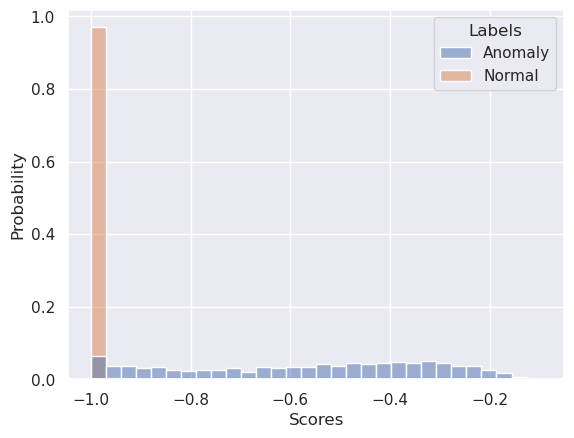

In [36]:
from pandas import DataFrame

df_1 = DataFrame()
df_1["Scores"] = scores.cpu().numpy()
df_1["Labels"] = ys >= 0
df_1["Labels"] = df_1["Labels"].apply(ood_label)
df_1["Method"] = "Implicit"

sb.histplot(data=df_1, x="Scores", hue="Labels", common_norm=False, stat="probability", bins=30)

# Examples 

torch.Size([1, 3, 32, 32])


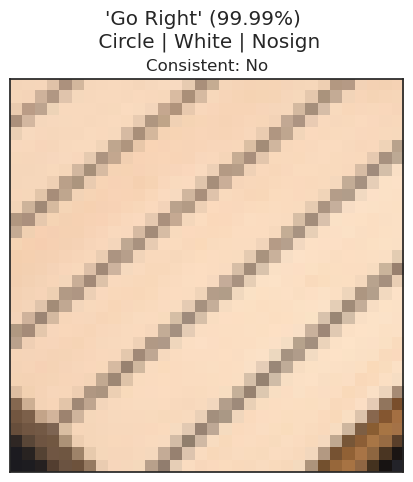

torch.Size([1, 3, 32, 32])


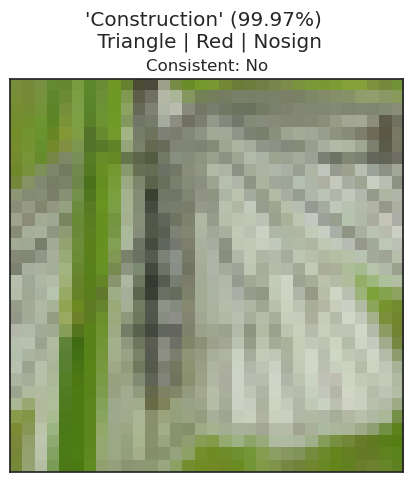

torch.Size([1, 3, 32, 32])


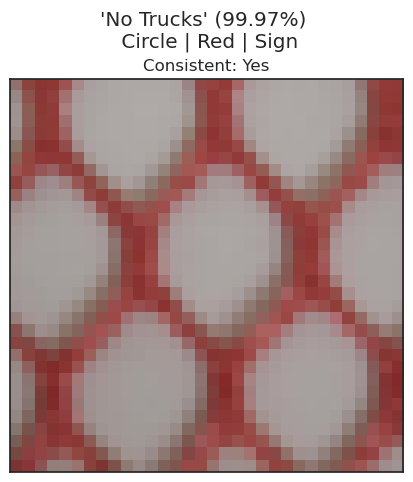

torch.Size([1, 3, 32, 32])


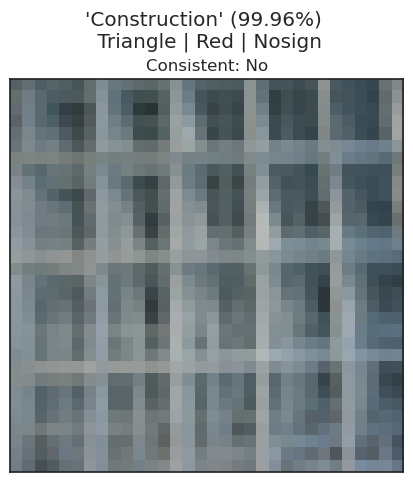

torch.Size([1, 3, 32, 32])


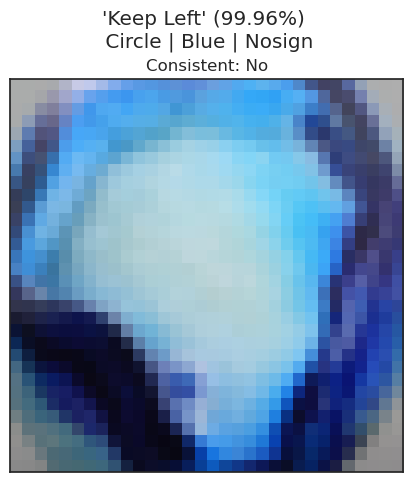

torch.Size([1, 3, 32, 32])


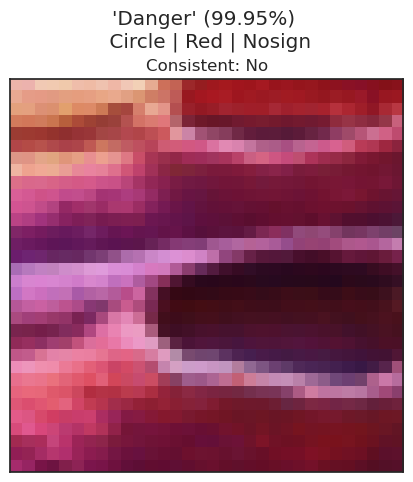

torch.Size([1, 3, 32, 32])


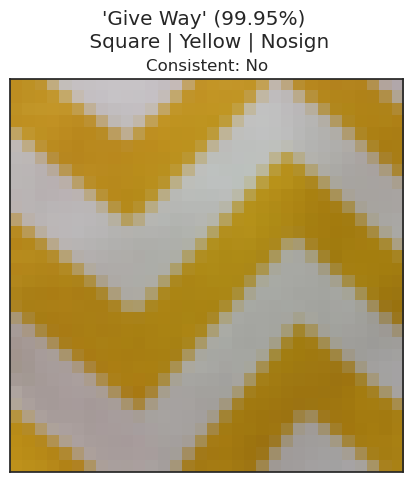

torch.Size([1, 3, 32, 32])


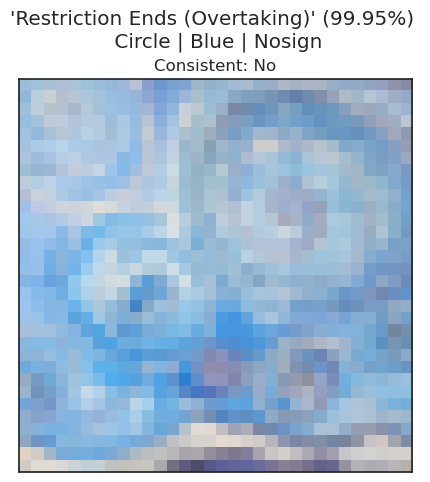

torch.Size([1, 3, 32, 32])


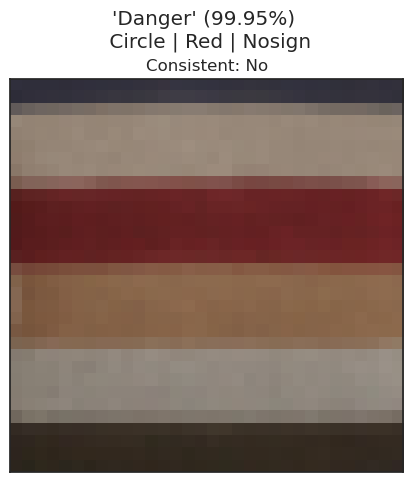

torch.Size([1, 3, 32, 32])


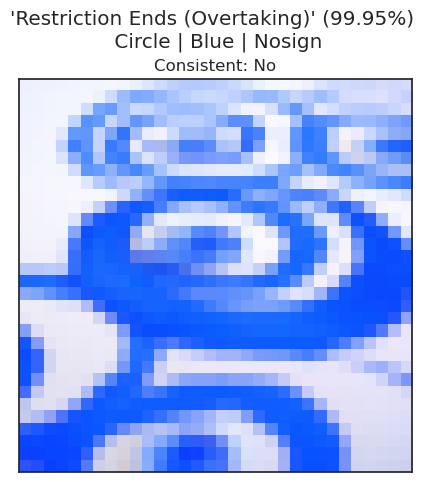

torch.Size([1, 3, 32, 32])


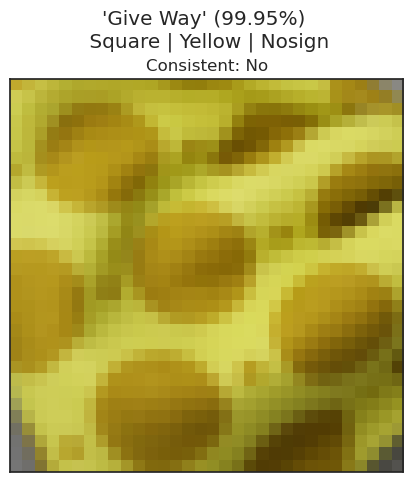

torch.Size([1, 3, 32, 32])


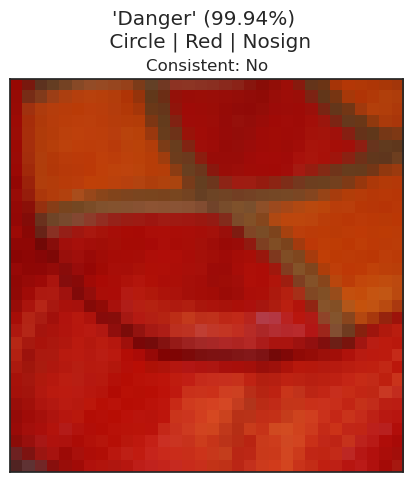

torch.Size([1, 3, 32, 32])


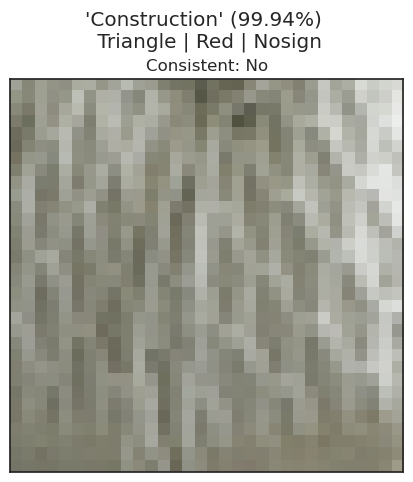

torch.Size([1, 3, 32, 32])


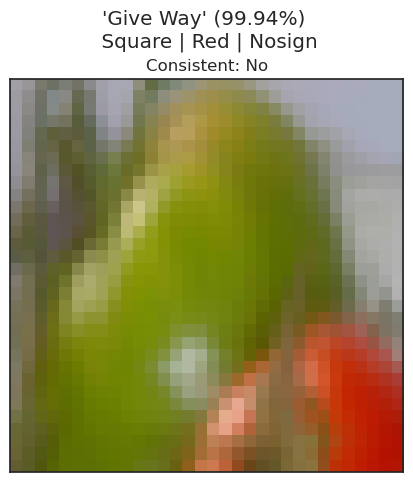

torch.Size([1, 3, 32, 32])


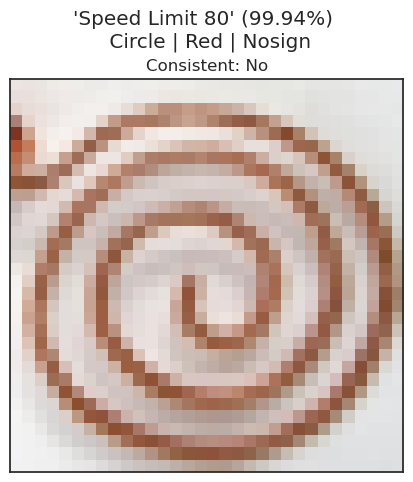

torch.Size([1, 3, 32, 32])


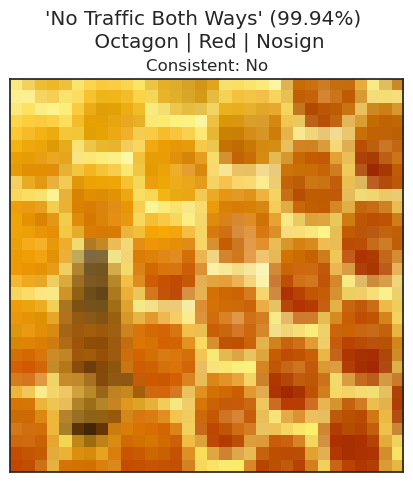

torch.Size([1, 3, 32, 32])


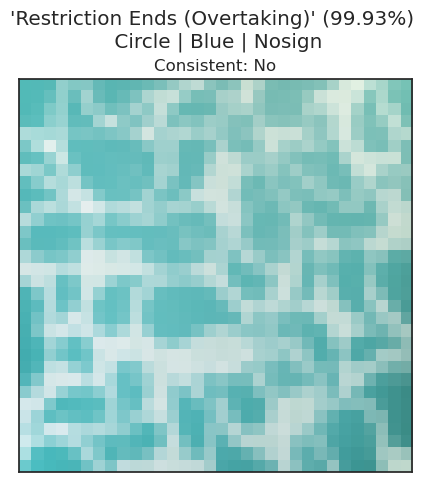

torch.Size([1, 3, 32, 32])


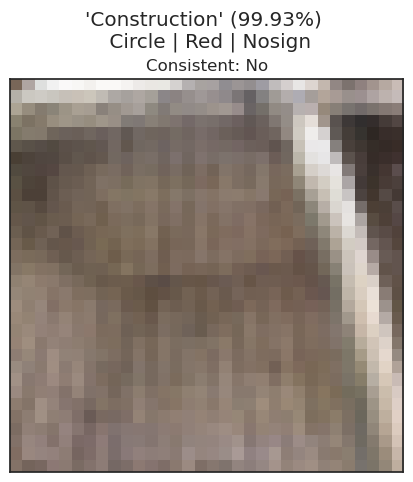

torch.Size([1, 3, 32, 32])


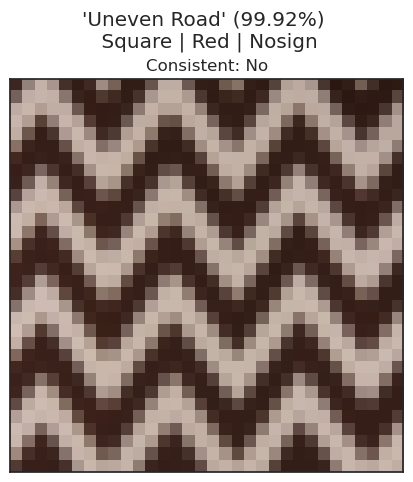

torch.Size([1, 3, 32, 32])


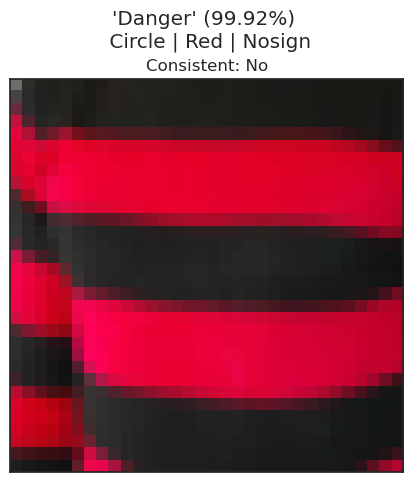

torch.Size([1, 3, 32, 32])


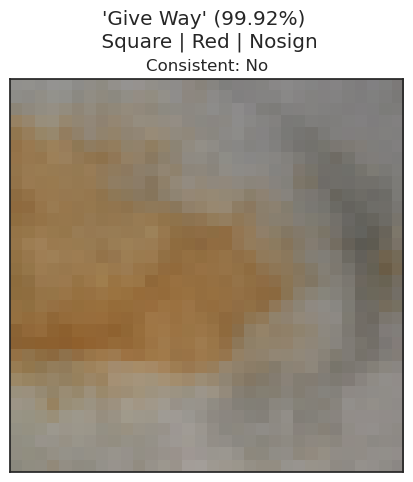

torch.Size([1, 3, 32, 32])


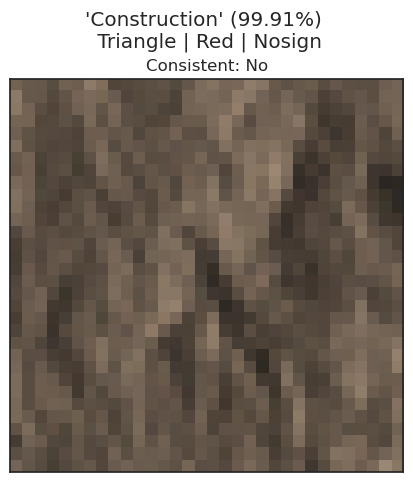

torch.Size([1, 3, 32, 32])


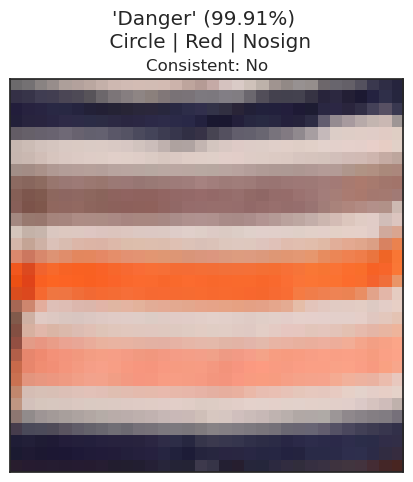

torch.Size([1, 3, 32, 32])


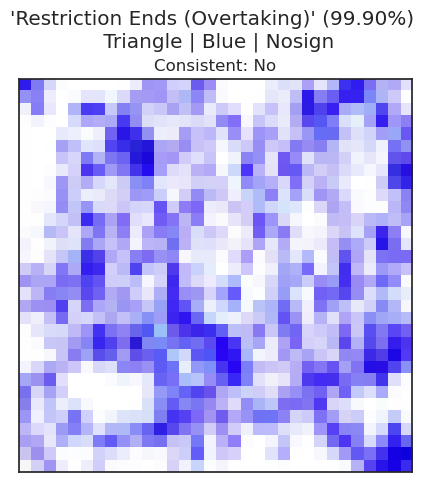

torch.Size([1, 3, 32, 32])


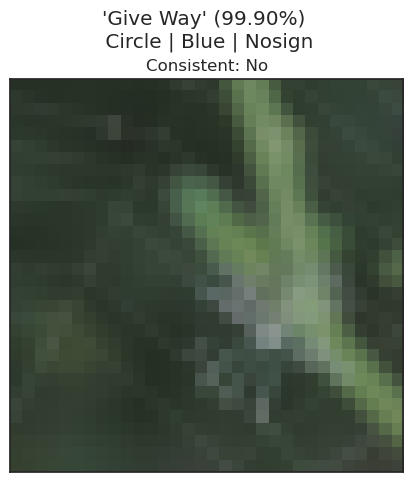

torch.Size([1, 3, 32, 32])


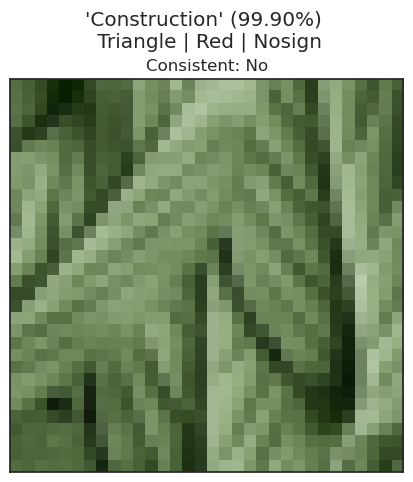

torch.Size([1, 3, 32, 32])


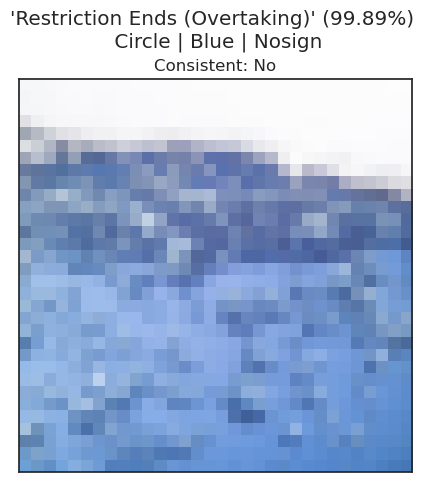

torch.Size([1, 3, 32, 32])


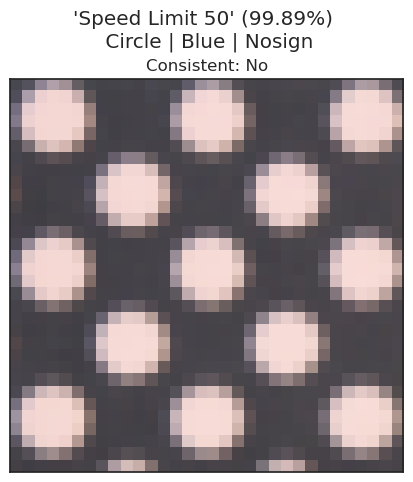

torch.Size([1, 3, 32, 32])


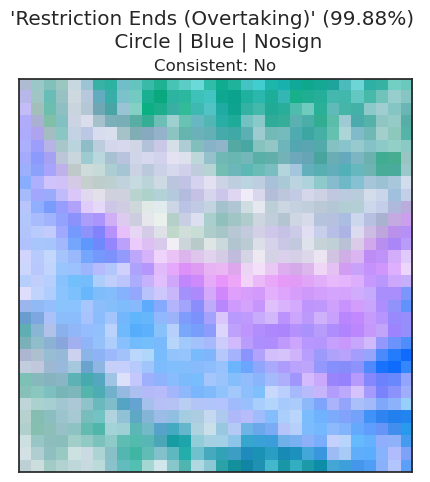

torch.Size([1, 3, 32, 32])


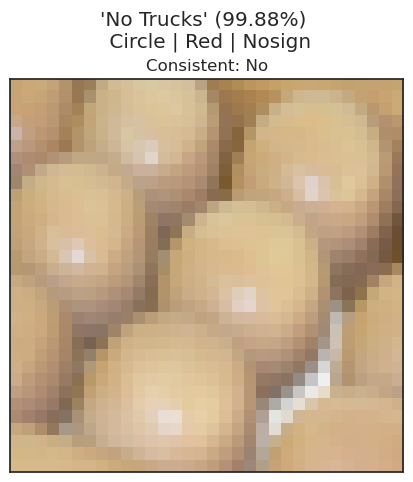

torch.Size([1, 3, 32, 32])


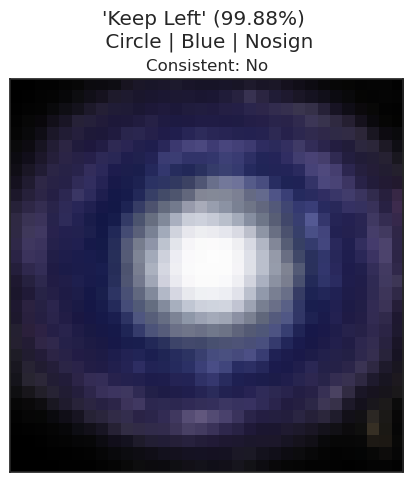

torch.Size([1, 3, 32, 32])


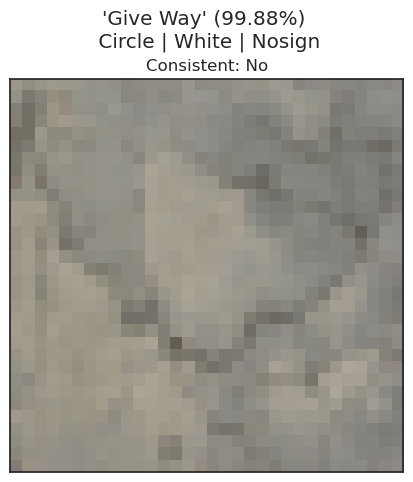

torch.Size([1, 3, 32, 32])


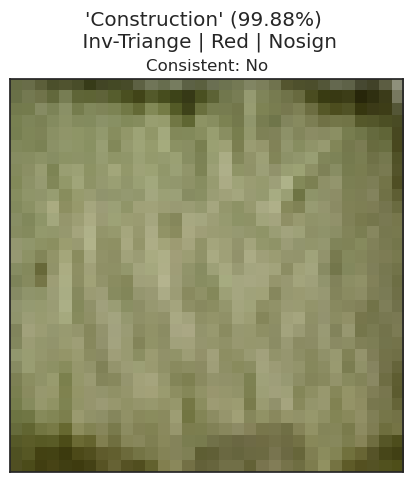

torch.Size([1, 3, 32, 32])


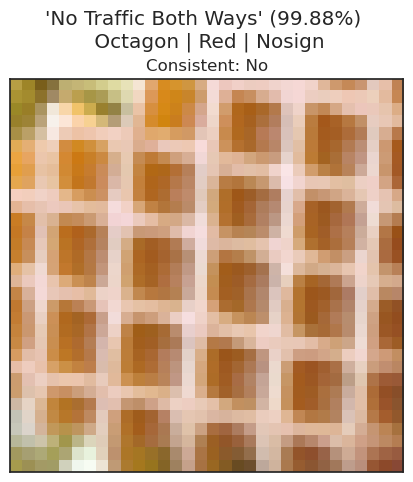

torch.Size([1, 3, 32, 32])


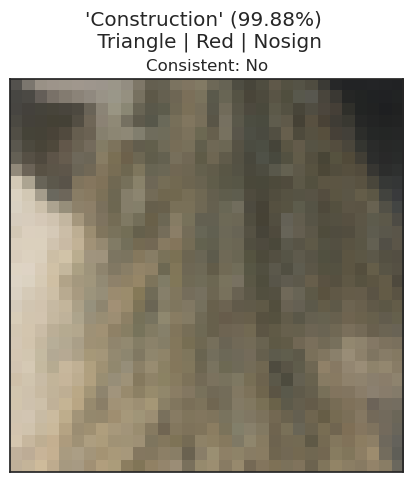

torch.Size([1, 3, 32, 32])


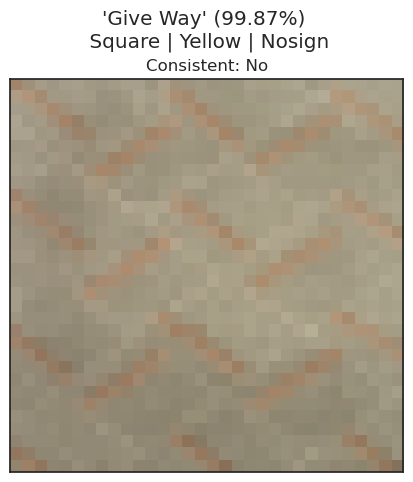

torch.Size([1, 3, 32, 32])


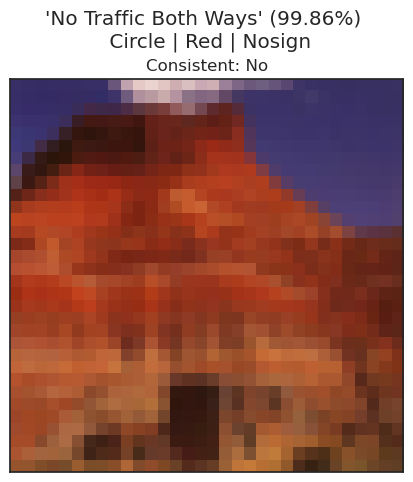

torch.Size([1, 3, 32, 32])


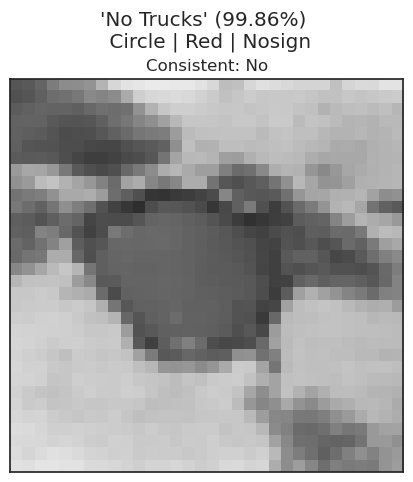

torch.Size([1, 3, 32, 32])


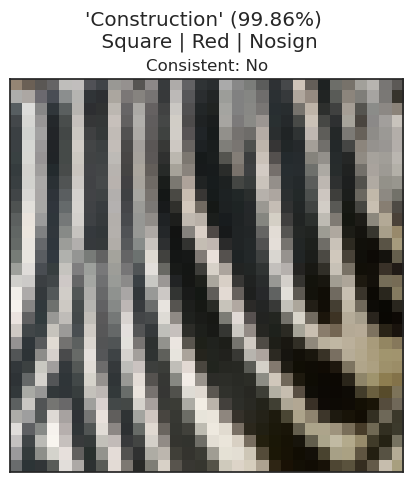

torch.Size([1, 3, 32, 32])


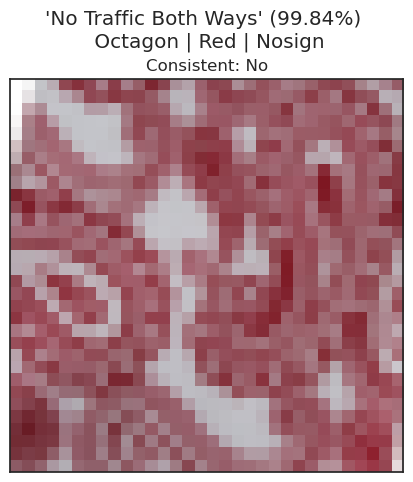

torch.Size([1, 3, 32, 32])


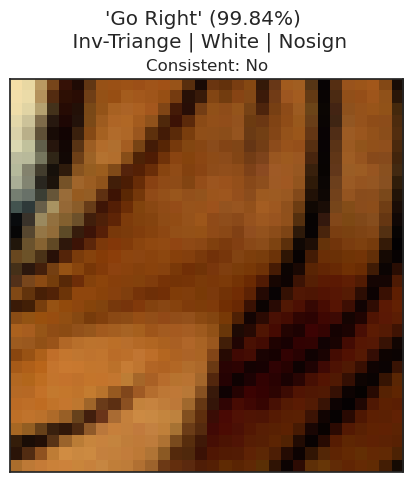

torch.Size([1, 3, 32, 32])


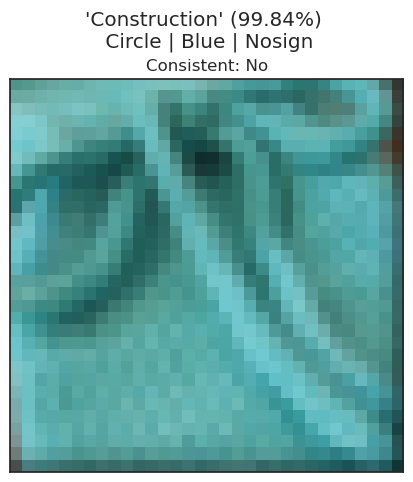

torch.Size([1, 3, 32, 32])


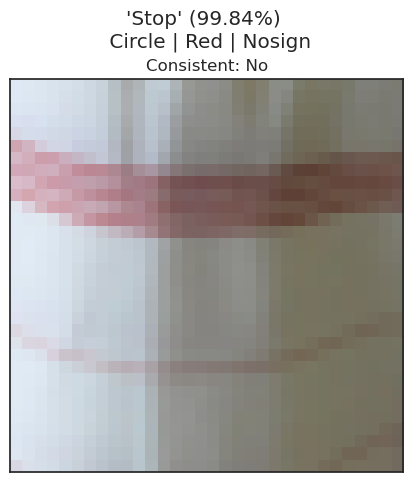

torch.Size([1, 3, 32, 32])


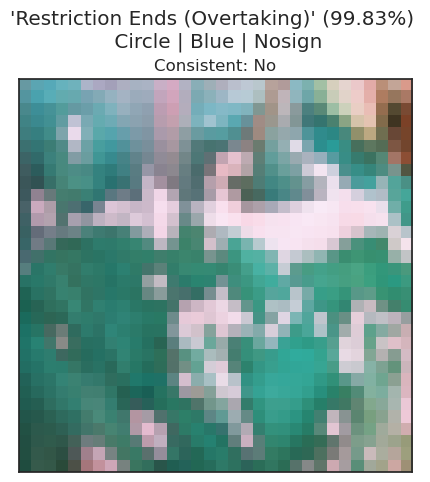

torch.Size([1, 3, 32, 32])


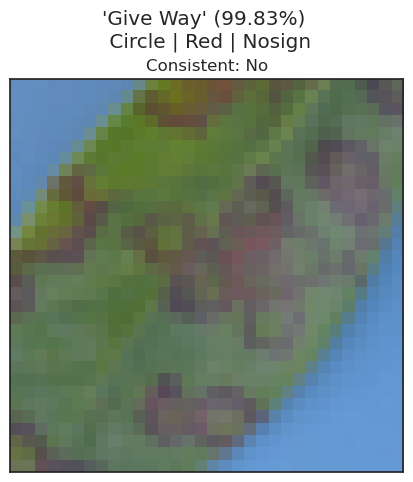

torch.Size([1, 3, 32, 32])


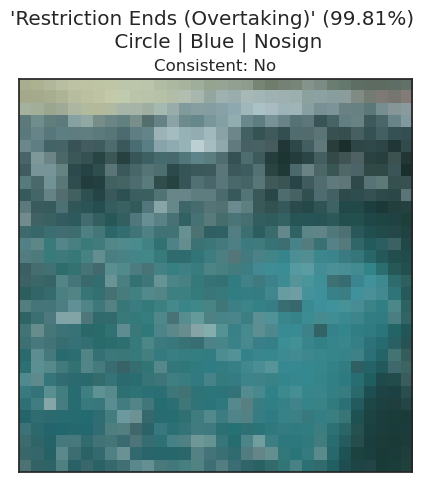

torch.Size([1, 3, 32, 32])


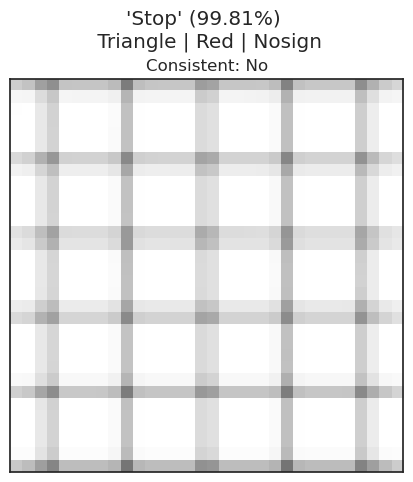

torch.Size([1, 3, 32, 32])


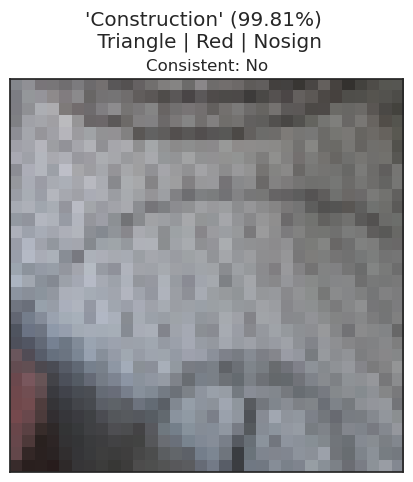

torch.Size([1, 3, 32, 32])


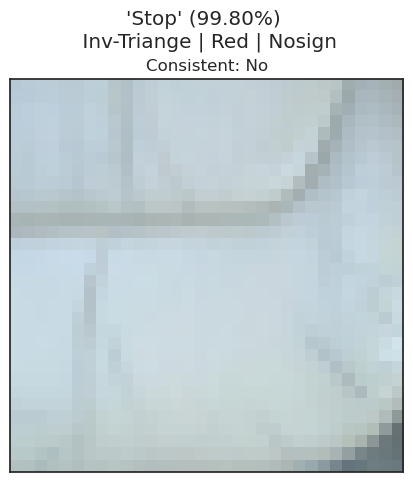

torch.Size([1, 3, 32, 32])


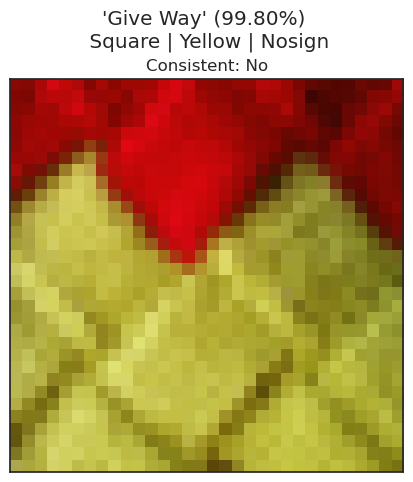

In [37]:
# custom_params = {"axes.spines.right": True, "axes.spines.top": True, "axes.spines.bottom": True, "axes.spines.left": True}
import matplotlib.pyplot as plt 
import numpy as np 

sb.set_theme(style="white")

sem_detector = SemanticDetector(
    label_net, 
    shape_net, 
    color_net, 
    GTSRB(root=root).class_to_shape, 
    GTSRB(root=root).class_to_color, 
    sign_net=shield_net
)

dataset = GTSRB(root=root)

top_values, top_indxs = (-scores[ys<0]).topk(50)
datasets = dataset_out_test +  test_in_data
imgs = [datasets[i][0] for i in top_indxs]

for n, img in enumerate(imgs):
    img_batch = img.unsqueeze(0).to(device)
    
    print(img_batch.shape)
    with torch.no_grad():
        l = label_net(img_batch)
        s = shape_net(img_batch)
        c = color_net(img_batch)
        o = shield_net(img_batch)
        
    sign_detected = o.max(dim=1).indices.cpu()
        
    my_score = sem_detector(img_batch)[0]
    
    lindex = l.argmax(dim=1).item()
    sindex = s.argmax(dim=1).item()
    cindex = c.argmax(dim=1).item()
    oindex = o.argmax(dim=1).item()
    
    lname = dataset.class_to_name[lindex]
    sname = dataset.shape_to_name[sindex]
    cname = dataset.color_to_name[cindex]
    oname = "Sign" if oindex else "NoSign"
    
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.moveaxis(img.numpy(), 0, -1))
    plt.suptitle(f"'{lname.title()}' ({l.softmax(dim=1).max().item():.2%}) \n {sname.title()} | {cname.title()} | {oname.title()}")
    plt.title(f"Consistent: {'Yes' if abs(my_score) > 0.0 else 'No'}") # 'Yes' if my_score > 0.0 else 'No'
    plt.tight_layout(pad=0.5)
    plt.savefig(f"img/prediction-example-{n}.pdf", bbox_inches="tight")
    plt.show()

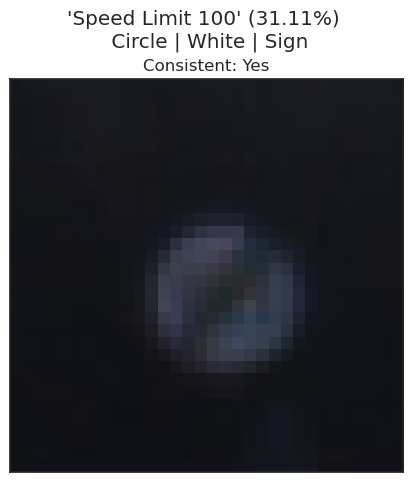

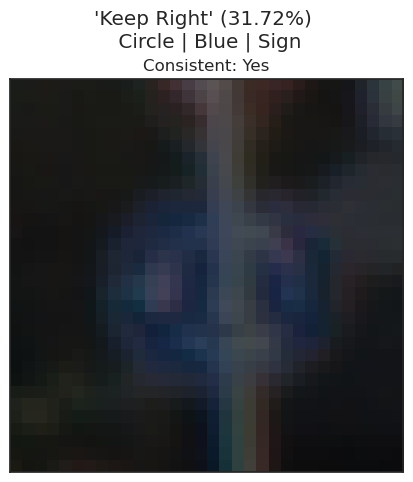

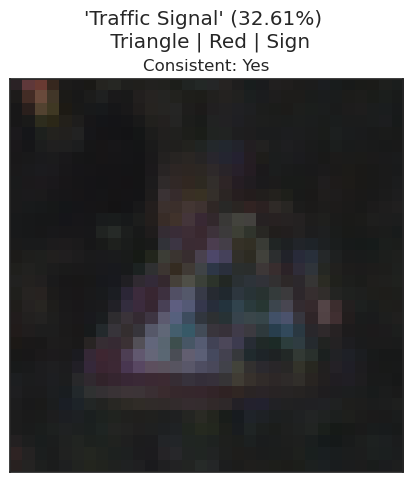

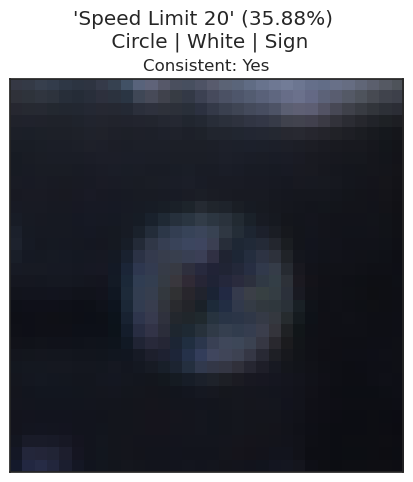

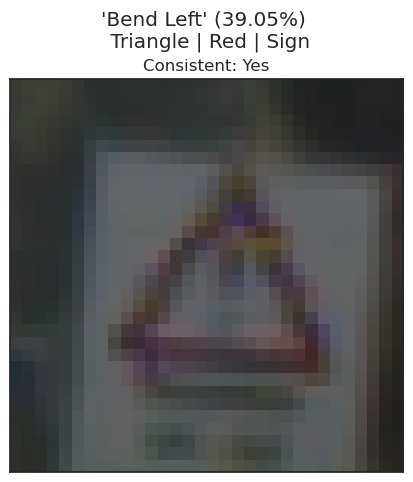

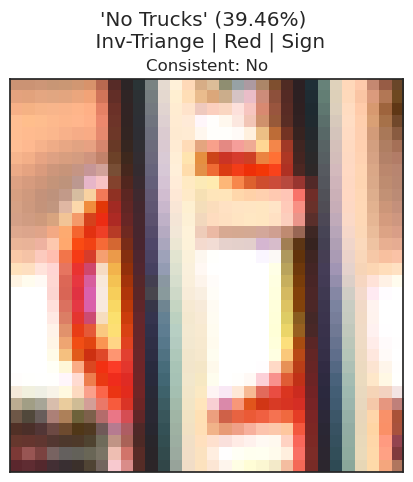

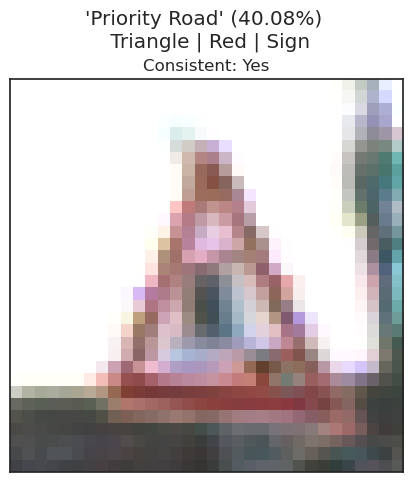

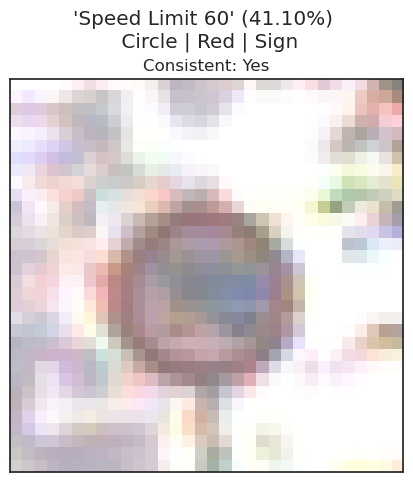

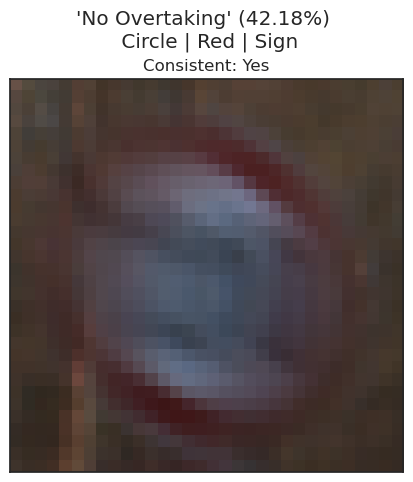

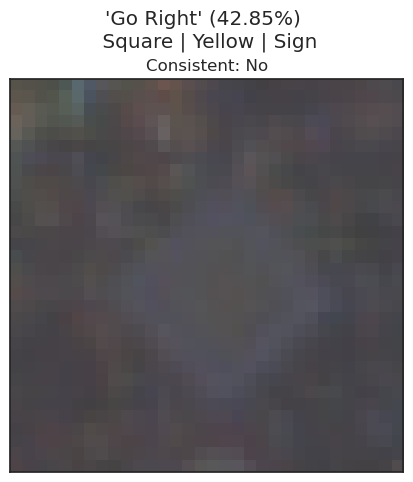

In [38]:
sem_detector = SemanticDetector(
    label_net, 
    shape_net, 
    color_net, 
    GTSRB(root=root).class_to_shape, 
    GTSRB(root=root).class_to_color, 
    sign_net=shield_net
)

top_values, top_indxs = (scores[ys>=0]).topk(10)

for n, i in enumerate([i for i in top_indxs]):
    img = xs[ys>=0][i]
    img_batch = img.unsqueeze(0).to(device)
    
    with torch.no_grad():
        l = label_net(img_batch)
        s = shape_net(img_batch)
        c = color_net(img_batch)
        o = shield_net(img_batch)
    
    # my_score = detector(img_batch)[0]
    my_score = my_scores[ys>=0][i]
    # score = scores[ys>=0][i]
    
    lindex = l.argmax(dim=1).item()
    sindex = s.argmax(dim=1).item()
    cindex = c.argmax(dim=1).item()
    oindex = o.argmax(dim=1).item()
        
    lname = dataset.class_to_name[lindex]
    sname = dataset.shape_to_name[sindex]
    cname = dataset.color_to_name[cindex]
    oname = "Sign" if oindex == 1 else "NoSign"
        
    plt.imshow(np.moveaxis(img.numpy(), 0, -1))
    plt.suptitle(f"'{lname.title()}' ({l.softmax(dim=1).max().item():.2%}) \n {sname.title()} | {cname.title()} | {oname}")
    plt.title(f"Consistent: {'Yes' if abs(my_score) > 0.0 else 'No'}") # 'Yes' if my_score > 0.0 else 'No'
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout(pad=0.5)
    plt.savefig(f"img/prediction-example-in-{n}.pdf", bbox_inches="tight")
    plt.show()

torch.Size([1, 3, 32, 32])


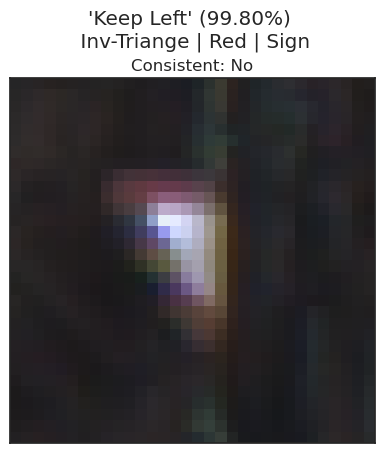

In [39]:
sem_detector = SemanticDetector(
    label_net, 
    shape_net, 
    color_net, 
    GTSRB(root=root).class_to_shape, 
    GTSRB(root=root).class_to_color, 
    sign_net=shield_net
)

# in-distribution where prediction was not correct and was rejected 
index = (ys>=0) & (ys != ys_hat.cpu()) & (my_scores.abs() == 0.0)
if index.sum().item() > 0:
    top_values, top_indxs = (-scores[index]).topk(1)

    for n, i in enumerate([i for i in top_indxs]):
        img = xs[index][i]
        img_batch = img.unsqueeze(0).to(device)

        print(img_batch.shape)
        with torch.no_grad():
            l = label_net(img_batch)
            s = shape_net(img_batch)
            c = color_net(img_batch)
            o = shield_net(img_batch)

        my_score = sem_detector(img_batch)[0]

        lindex = l.argmax(dim=1).item()
        sindex = s.argmax(dim=1).item()
        cindex = c.argmax(dim=1).item()

        lname = dataset.class_to_name[lindex]
        sname = dataset.shape_to_name[sindex]
        cname = dataset.color_to_name[cindex]
        oname = "Sign" if oindex == 1 else "NoSign"

        plt.imshow(np.moveaxis(img.numpy(), 0, -1))
        plt.suptitle(f"'{lname.title()}' ({l.softmax(dim=1).max().item():.2%}) \n {sname.title()} | {cname.title()} | {oname.title()}")
        plt.title(f"Consistent: {'Yes' if abs(my_score) > 0.0 else 'No'}") # 'Yes' if my_score > 0.0 else 'No'
        plt.tight_layout(pad=0.5)
        plt.xticks([])
        plt.yticks([])
        plt.savefig(f"img/prediction-example-in-error-{n}.pdf", bbox_inches="tight")
        plt.show()

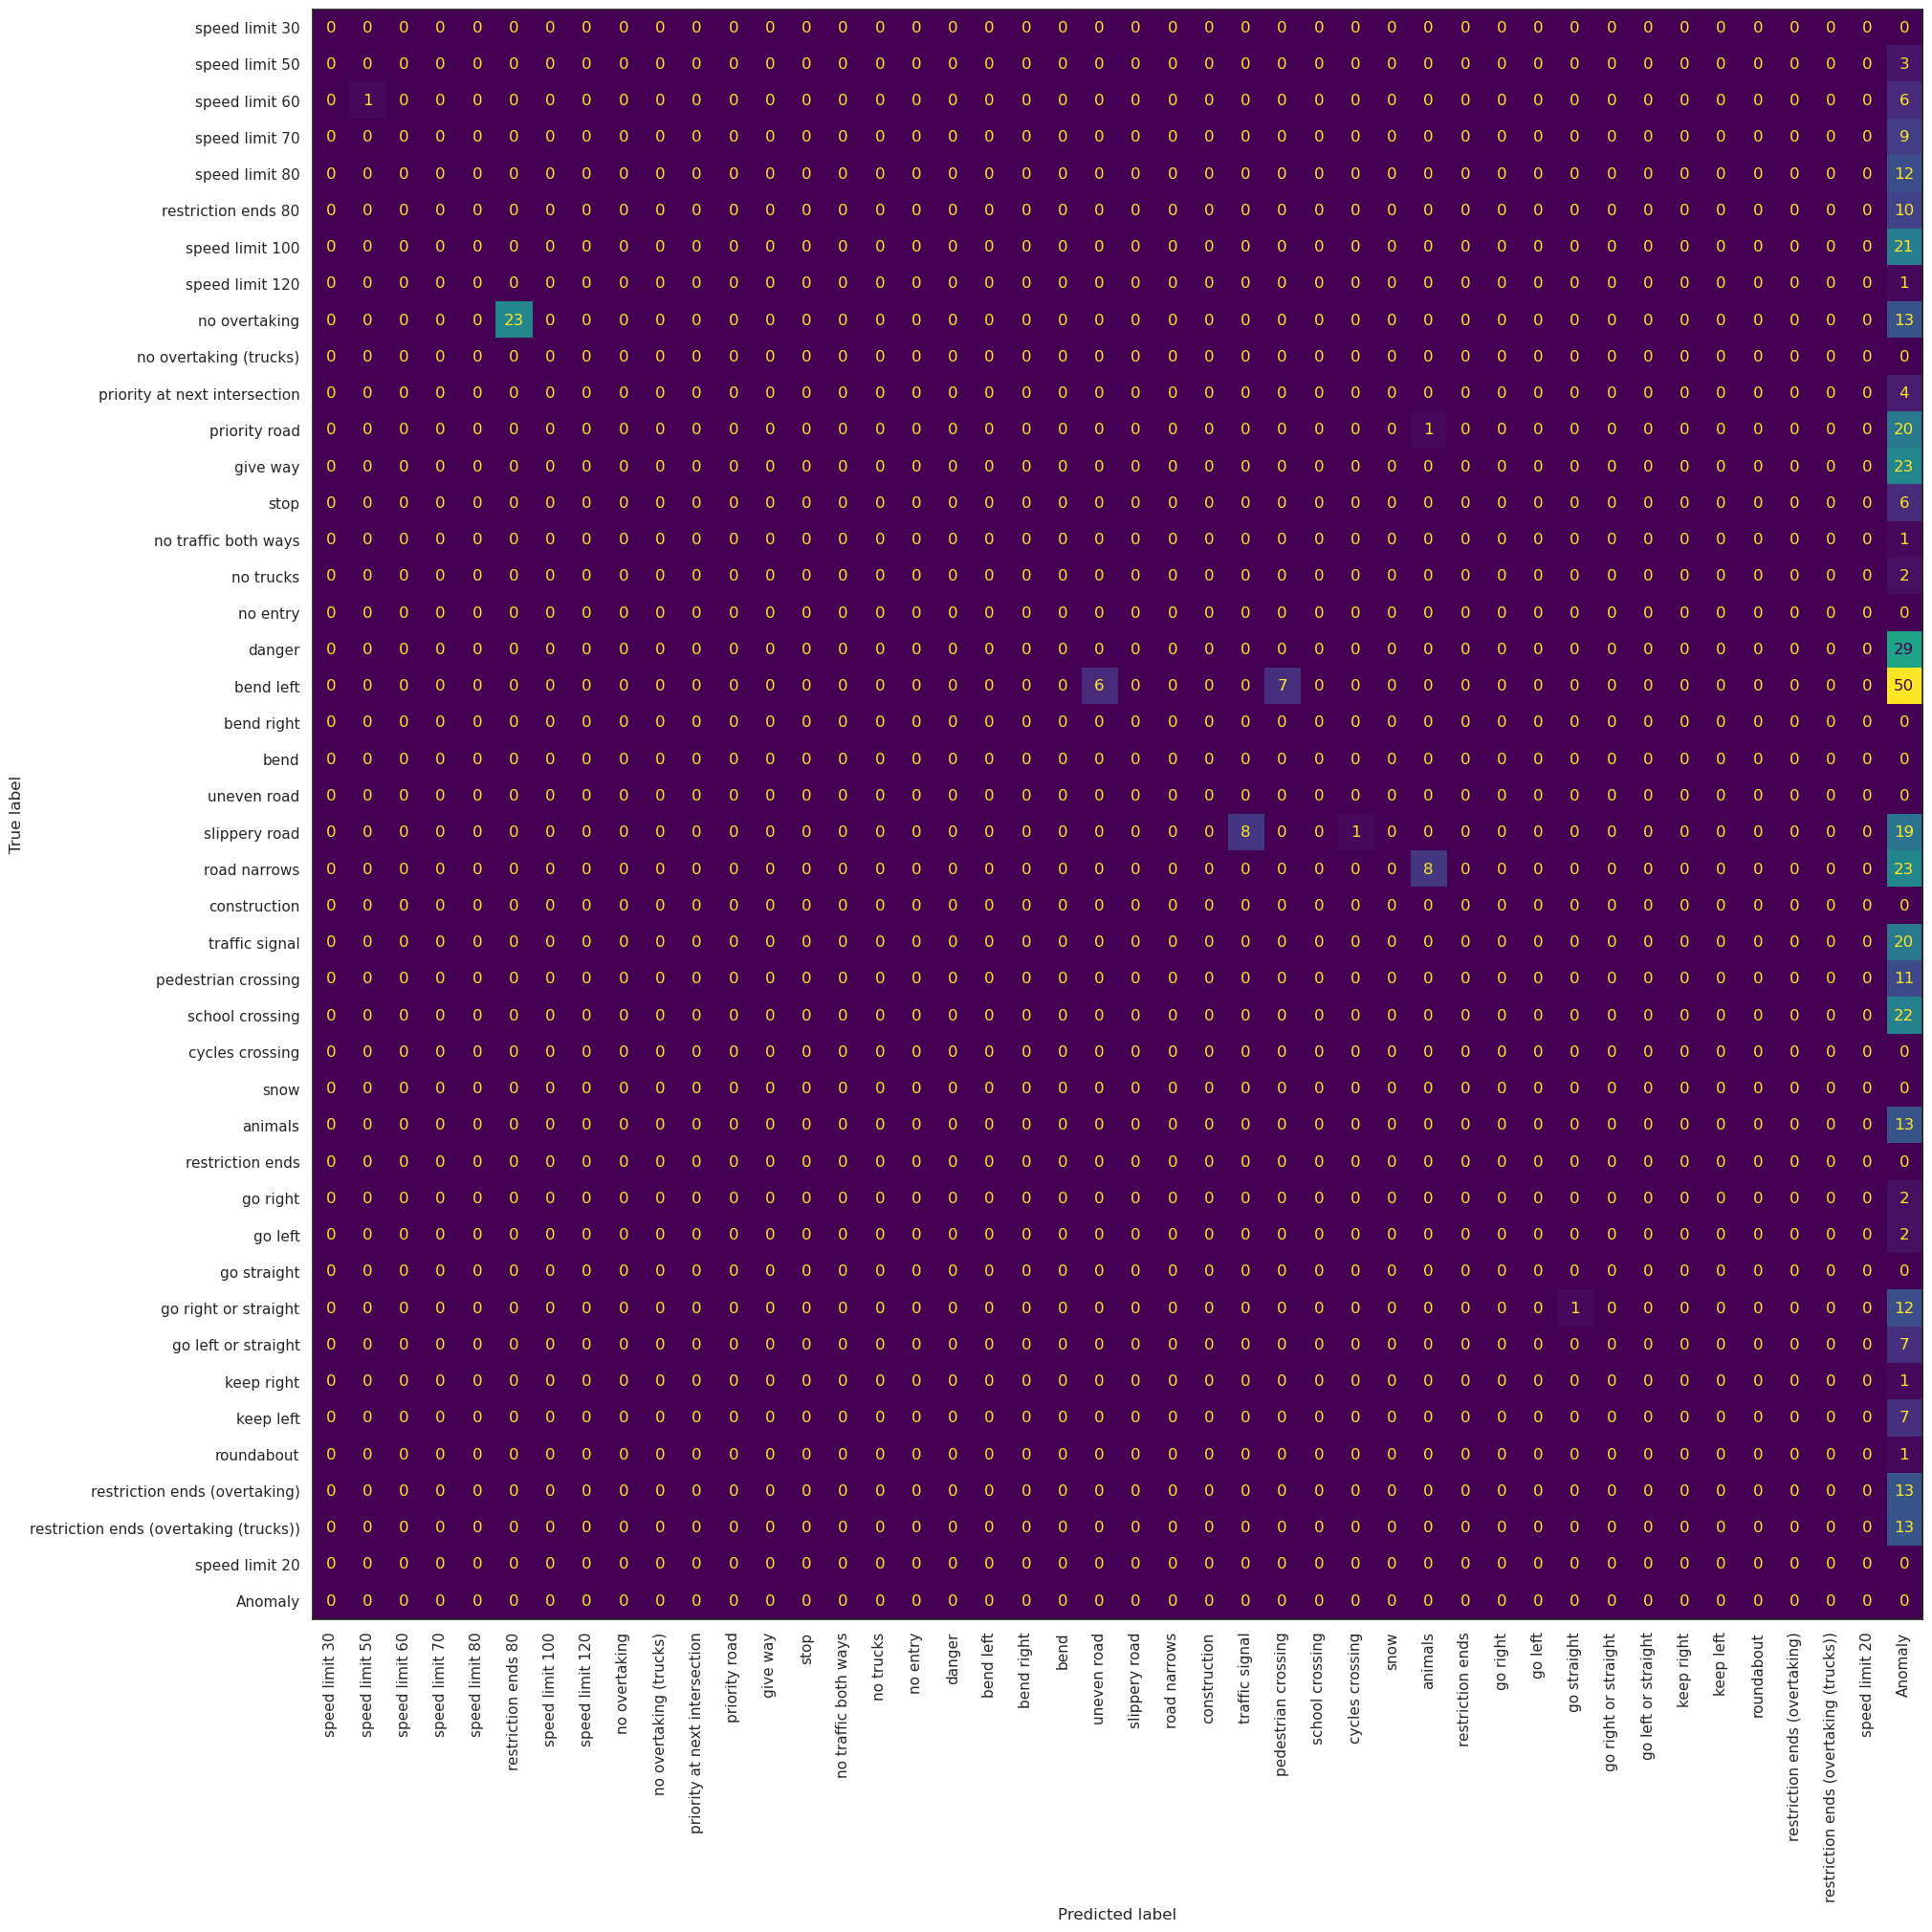

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sb 

ys_hat_anom = ys_hat.clone()
ys_hat_anom[my_scores > -0.99] = 44 

fig, ax = plt.subplots(figsize=(20,20))
m = confusion_matrix(ys[ys >= 0], ys_hat_anom[ys >= 0])

for i in range(m.shape[0]):
    m[i,i] = 0
    
disp = ConfusionMatrixDisplay(m, display_labels=list(dataset.class_to_name.values()) + ["Anomaly"])
disp.plot(ax=ax, xticks_rotation="vertical", colorbar=False)

plt.tight_layout(pad=0)

plt.savefig("img/confusion.pdf")
plt.savefig("img/confusion.jpg", dpi=300, bbox_inches="tight")

In [41]:
min_score = my_scores[ys < 0][my_scores[ys < 0] != -1].min().item() - 0.00001

ys_hat_anom = ys_hat.clone()
ys_hat_anom[my_scores > -0.99] = -1 

(ys_hat_anom[ys >= 0] == 44).sum()

print(f"Total number of street signs {(ys >= 0).sum()}")
print(f"Total number of anomalies {(ys < 0).sum()}")
print(f"Signs mistakenly marked as anomalies (no matter prediction) {(ys_hat_anom[ys >= 0] < 0).sum()}")
print(f"Signs mistakenly marked as anomalies (correct sign predicted) {(ys_hat_anom[ys == ys_hat] < 0).sum()}")
print(f"Signs mistakenly marked as anomalies (false sign predicted) {(ys_hat_anom[(ys != ys_hat) & (ys >= 0)] < 0).sum()}")

print(f"Signs maked as non-anomalous (false sign predicted) {(  (ys_hat_anom >= 0) & (ys_hat_anom != ys) ).sum() }")
print(f"Anomaly mistakenly marked as sign (no matter prediction) {(ys_hat_anom[ys < 0] >= 0).sum()}")

t = (ys_hat_anom[ys == ys_hat] < 0).sum() + ((ys_hat_anom >= 0) & (ys_hat_anom != ys)).sum() + (ys_hat_anom[ys < 0] >= 0).sum()
total = ys.shape[0]
print(f"Instances where our decision was not optimal: {t}/{total}={t/total:.3%}")

Total number of street signs 12630
Total number of anomalies 5640
Signs mistakenly marked as anomalies (no matter prediction) 376
Signs mistakenly marked as anomalies (correct sign predicted) 261
Signs mistakenly marked as anomalies (false sign predicted) 115
Signs maked as non-anomalous (false sign predicted) 57
Anomaly mistakenly marked as sign (no matter prediction) 1
Instances where our decision was not optimal: 319/18270=1.746%


In [42]:
red_classes = [k for k, v in dataset.class_to_color.items() if dataset.color_to_name[v] == "red"]
red_classes.sort()
# red_classes

In [43]:
detector = EnsembleDetector(label_net, shape_net, color_net)

with torch.no_grad():
    metrics = OODMetrics()
    for x, y in loader:
        metrics.update(detector(x.to(device)), y.to(device))

metrics_ensemble = metrics.compute()
print(metrics_ensemble)

{'AUROC': 0.9967834949493408, 'AUPR-IN': 0.9922196865081787, 'AUPR-OUT': 0.9986470341682434, 'ACC95TPR': 0.9735631942749023, 'FPR95TPR': 0.015914488583803177}


In [44]:
sem_detector = SemanticDetector(
    label_net, 
    shape_net, 
    color_net, 
    GTSRB(root=root).class_to_shape, 
    GTSRB(root=root).class_to_color, 
    sign_net=shield_net
)

scores = []
ys = []

with torch.no_grad():
    for x, y in loader:
        scores.append(sem_detector(x.to(device)).cpu())
        ys.append(y)
        
scores = torch.cat(scores)
ys = torch.cat(ys)


metrics = OODMetrics()
metrics.update(scores, ys)
metrics_semantic = metrics.compute()

<AxesSubplot: xlabel='Scores', ylabel='Probability'>

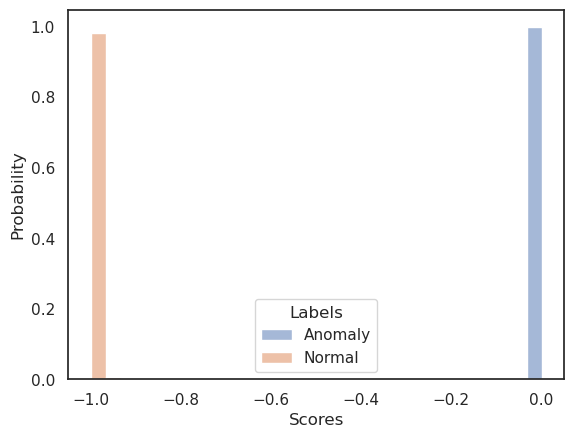

In [45]:
df_2 = DataFrame()
df_2["Scores"] = scores.cpu().numpy()
df_2["Labels"] = ys >= 0
df_2["Labels"] = df_2["Labels"].apply(ood_label)
df_2["Method"] = "Explicit"

sb.histplot(data=df_2, x="Scores", hue="Labels", common_norm=False, stat="probability", bins=30)

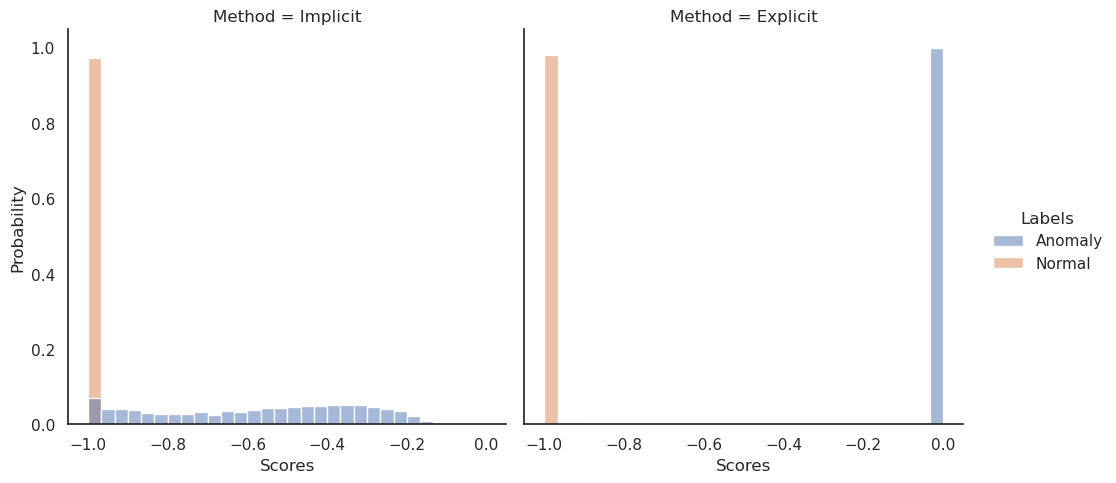

In [46]:
sb.displot(pd.concat([df_1, df_2]).reset_index(), x="Scores", hue="Labels", col="Method", stat="probability", bins=30, kind="hist",  common_norm=False)

In [47]:
metrics_semantic["Method"] = "Explicit"
metrics_semantic

{'AUROC': 0.9991172552108765,
 'AUPR-IN': 0.9980280995368958,
 'AUPR-OUT': 0.9997257590293884,
 'ACC95TPR': 0.9981937408447266,
 'FPR95TPR': 0.0017418843926861882,
 'Method': 'Explicit'}

In [48]:
metrics_softmax["Method"] = "Implicit"

In [49]:
metrics_ensemble["Method"] = "Ensemble"

In [50]:
result_df = pd.DataFrame([metrics_semantic, metrics_softmax, metrics_ensemble])

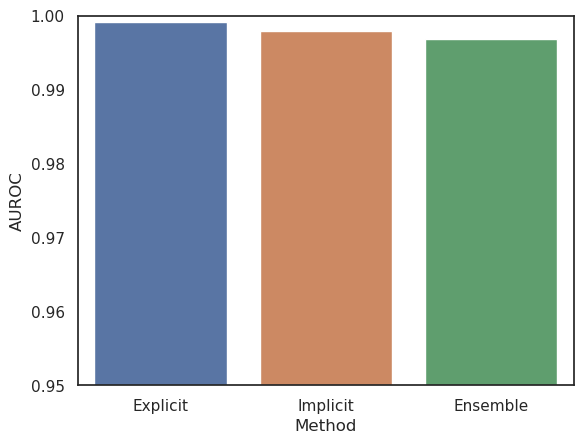

In [51]:
# plot distplot
fig, ax = plt.subplots()
sb.barplot(data=result_df, x="Method", y="AUROC")

# change the limits of X-axis
ax.set_ylim(0.95, 1)
plt.show()

In [52]:
print((result_df.groupby(by="Method").mean() * 100)[["AUROC", "AUPR-IN", "AUPR-OUT", "FPR95TPR"]].to_latex(float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
{} &  AUROC &  AUPR-IN &  AUPR-OUT &  FPR95TPR \\
Method   &        &          &           &           \\
\midrule
Ensemble &  99.68 &    99.22 &     99.86 &      1.59 \\
Explicit &  99.91 &    99.80 &     99.97 &      0.17 \\
Implicit &  99.79 &    99.18 &     99.96 &      0.17 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_4049143/3654264474.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print((result_df.groupby(by="Method").mean() * 100)[["AUROC", "AUPR-IN", "AUPR-OUT", "FPR95TPR"]].to_latex(float_format="%.2f"))
